In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE,ADASYN 
from PIL import Image




Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
##utility functions

def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'ASETRI'
    elif x == 1:
        return 'EPTBOT'
    elif x == 2:
        return 'MYOEMA'
    elif x == 3:
        return 'PIPKUH'
    elif x == 4:
        return 'RHIMUS'
    elif x == 5:
        return 'RHYNAS'
    elif x == 6:
        return 'ROUAEG'
    elif x == 7:
        return 'TAPPER'
    else:
        return 'Unknown'
    

def makeOverSamplesSMOTE(X,y):
 #input DataFrame
 #X →Independent Variable in DataFrame\
 #y →dependent Variable in Pandas DataFrame format
    sm = ADASYN()
    X, y = sm.fit_resample(X, y)
    return(X,y)

In [4]:
image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1799
TAPPER     429
PIPKUH     303
RHYNAS     271
EPTBOT     131
ROUAEG     121
MYOEMA     114
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((341, 224)) 
    spectrogram = np.array(spectrogram) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))
    
# print(X_all)
# print(Y_all)
# # plt.imshow(X_all[0])


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

#normalize
print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 

# print(X_all)
# print(Y_all)

(3193, 224, 341, 3)
(3193,)


In [7]:
# train /test= 80/20% split
# Data is stratified

X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)
print("Before OverSampling\nX_train: shape= ",X_train.shape)
print("Y_train: shape= ",Y_train.shape)
#oversample

Y_train_labelled=[]
for i in range(len(Y_train)):
    Y_train_labelled.append(np.argmax(Y_train[i]))
       
print('Original trainingset shape %s' %  [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])       
X_dims=X_train.shape
X_train= X_train.reshape(-1,X_dims[1]*X_dims[2]*X_dims[3])
X_train, Y_train_labelled= makeOverSamplesSMOTE(X_train, Y_train_labelled)
print('Resampled training set shape %s' % [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])


#reshape X_all
X_train= X_train.reshape(-1,X_dims[1],X_dims[2],X_dims[3])

# update Y_train
Y_train= np_utils.to_categorical(Y_train_labelled, num_classes=8)

print("After OverSampling\nX_train: shape= ",X_train.shape)
print("Y_train: shape= ",Y_train.shape)

Before OverSampling
X_train: shape=  (2554, 224, 341, 3)
Y_train: shape=  (2554, 8)
Original trainingset shape [('RHYNAS', 217), ('EPTBOT', 105), ('RHIMUS', 1439), ('TAPPER', 343), ('ASETRI', 20), ('PIPKUH', 242), ('MYOEMA', 91), ('ROUAEG', 97)]
Resampled training set shape [('RHYNAS', 1439), ('EPTBOT', 1441), ('RHIMUS', 1439), ('TAPPER', 1446), ('ASETRI', 1439), ('PIPKUH', 1452), ('MYOEMA', 1471), ('ROUAEG', 1430)]
After OverSampling
X_train: shape=  (11557, 224, 341, 3)
Y_train: shape=  (11557, 8)


<h2>Model Building</h2>

In [10]:

   def build_current_model():
    inp = Input(shape=(224,341,3))
    
    c1 = Convolution2D(filters=128,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)

    
    c2 = Convolution2D(filters=256,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)
    
    c2 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)
    
    c3 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.4)(mpool)
    
    f = Flatten()(mpool)
    
    x_dense = Dense(2048)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)

    
    x_dense = Dense(1024)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)
    
    x_dense = Dense(512)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    
    model = Model(inputs=inp, outputs=x_out)
    model.compile(optimizer=Adam(lr=0.003), 
                  loss='categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model




In [11]:
model = build_current_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 341, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 171, 128)     18944     
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 171, 128)     512       
_________________________________________________________________
activation (Activation)      (None, 112, 171, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 86, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 86, 128)       0         
_________

In [ ]:
#tf.keras.utils.plot_model(model, "Model2V7.png", show_shapes=True)

In [12]:

my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_acc',patience=25,verbose=1, mode='max',restore_best_weights=True)]

history = model.fit(X_train, Y_train, 
              epochs = 100, 
              validation_split=0.1, 
              verbose=1, 
              batch_size = 8,
#             class_weight = class_weight
                 callbacks=my_callbacks   )

history_info = history.history



Train on 10401 samples, validate on 1156 samples
Epoch 1/100
10401/10401 [==============================] - 48s 5ms/sample - loss: 1.7487 - acc: 0.3778 - val_loss: 5.6675 - val_acc: 0.0026
Epoch 2/100
10401/10401 [==============================] - 47s 5ms/sample - loss: 1.0537 - acc: 0.6148 - val_loss: 3.1324 - val_acc: 0.0458
Epoch 3/100
10401/10401 [==============================] - 48s 5ms/sample - loss: 0.6520 - acc: 0.7674 - val_loss: 2.0397 - val_acc: 0.2102
Epoch 4/100
10401/10401 [==============================] - 48s 5ms/sample - loss: 0.4327 - acc: 0.8519 - val_loss: 2.0685 - val_acc: 0.4118
Epoch 5/100
10401/10401 [==============================] - 48s 5ms/sample - loss: 0.3013 - acc: 0.9012 - val_loss: 1.1585 - val_acc: 0.5770
Epoch 6/100
10401/10401 [==============================] - 49s 5ms/sample - loss: 0.2250 - acc: 0.9300 - val_loss: 1.2166 - val_acc: 0.6107
Epoch 7/100
10401/10401 [==============================] - 49s 5ms/sample - loss: 0.1843 - acc: 0.9431 - val_lo

Epoch 59/100
10401/10401 [==============================] - 49s 5ms/sample - loss: 0.0179 - acc: 0.9952 - val_loss: 0.0052 - val_acc: 0.9983
Epoch 60/100
10401/10401 [==============================] - 49s 5ms/sample - loss: 0.0154 - acc: 0.9959 - val_loss: 0.0021 - val_acc: 0.9991
Epoch 61/100
10401/10401 [==============================] - 49s 5ms/sample - loss: 0.0196 - acc: 0.9942 - val_loss: 0.0132 - val_acc: 0.9948
Epoch 62/100
10401/10401 [==============================] - 49s 5ms/sample - loss: 0.0263 - acc: 0.9930 - val_loss: 0.0781 - val_acc: 0.9758
Epoch 63/100
10401/10401 [==============================] - 49s 5ms/sample - loss: 0.0325 - acc: 0.9925 - val_loss: 0.0270 - val_acc: 0.9939
Epoch 00063: early stopping


<h2>Evaluation (Basic)</h2>

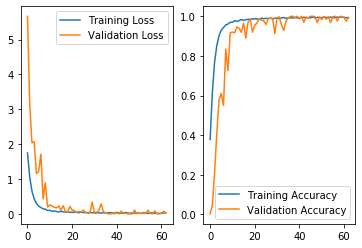

In [23]:
## Loss and accuracy history
_, axs = plt.subplots(ncols=2)
df_history_info = pd.DataFrame(history_info) 


sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

sns.lineplot(data=df_history_info['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
sns.lineplot(data=df_history_info['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [24]:
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

[[  5   0   0   0   0   0   0   0]
 [  0  25   0   0   0   0   0   1]
 [  0   0  18   0   2   0   0   3]
 [  0   0   0  59   2   0   0   0]
 [  0   1   1   0 357   0   1   0]
 [  0   0   2   1   1  50   0   0]
 [  0   0   1   0   2   0  20   1]
 [  0   0   0   0   2   0   0  84]]


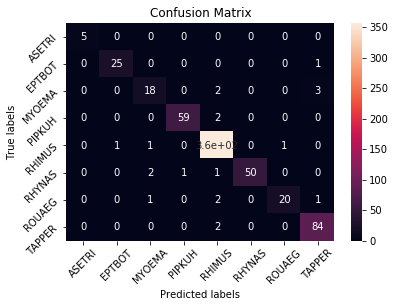

In [25]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['ASETRI','EPTBOT','MYOEMA','PIPKUH','RHIMUS','RHYNAS', 'ROUAEG', 'TAPPER']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [16]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.9671361502347418


In [17]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

              precision    recall  f1-score   support

      ASETRI       1.00      1.00      1.00         5
      EPTBOT       0.96      0.96      0.96        26
      MYOEMA       0.82      0.78      0.80        23
      PIPKUH       0.98      0.97      0.98        61
      RHIMUS       0.98      0.99      0.98       360
      RHYNAS       1.00      0.93      0.96        54
      ROUAEG       0.95      0.83      0.89        24
      TAPPER       0.94      0.98      0.96        86

    accuracy                           0.97       639
   macro avg       0.95      0.93      0.94       639
weighted avg       0.97      0.97      0.97       639



In [18]:
##ROC AUC Scores
from sklearn.metrics import roc_auc_score
print('One-vs-One ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovo'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovo'), '(weighted by prevalence)')


print()
print('One-vs-Rest ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovr'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovr'), '(weighted by prevalence)')

One-vs-One ROC AUC scores:
0.9921223378760874 (macro)
0.9953477869016885 (weighted by prevalence)

One-vs-Rest ROC AUC scores:
0.9945803980388042 (macro)
0.9976448011729748 (weighted by prevalence)


/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


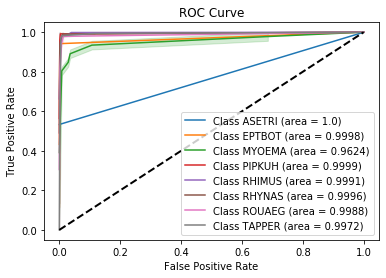

In [19]:
## ROC Curves
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import interp

### The following curves are generated s.t each point is a model from differing thresholds

### ROC Curves + AUC per class

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve')

fpr = [0] * 8
tpr = [0] * 8
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:,i], Y_pred[:,i])
    auc_val = auc(fpr[i], tpr[i])
    auc_val = np.around(auc_val,4)
    sns.lineplot(x=fpr[i],y=tpr[i],ax=axs, label='Class '+ getSpecies(i) +' (area = ' + str(auc_val) + ')', legend='brief')

#### Micro/Macro ROC Curves + AUC over all classes

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(8)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(8):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 8

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)
fpr_micro, tpr_micro,_ = roc_curve(Y_test.ravel(), Y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


## Diagonal line for comparison
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


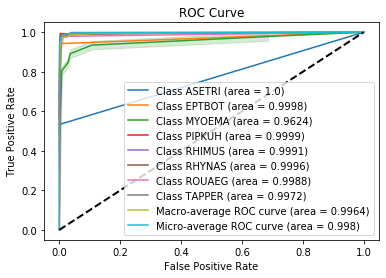

In [20]:
## ROC Curves
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import interp

### The following curves are generated s.t each point is a model from differing thresholds

### ROC Curves + AUC per class

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve')

fpr = [0] * 8
tpr = [0] * 8
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:,i], Y_pred[:,i])
    auc_val = auc(fpr[i], tpr[i])
    auc_val = np.around(auc_val,4)
    sns.lineplot(x=fpr[i],y=tpr[i],ax=axs, label='Class '+ getSpecies(i) +' (area = ' + str(auc_val) + ')', legend='brief')

#### Micro/Macro ROC Curves + AUC over all classes

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(8)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(8):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 8

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)
fpr_micro, tpr_micro,_ = roc_curve(Y_test.ravel(), Y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

roc_auc_macro = np.around(roc_auc_macro,4)
roc_auc_micro = np.around(roc_auc_micro,4)
sns.lineplot(x=fpr_macro,y=tpr_macro,ax=axs, label='Macro-average ROC curve (area = ' + str(roc_auc_macro) + ')', legend='brief')
sns.lineplot(x=fpr_micro,y=tpr_micro,ax=axs, label='Micro-average ROC curve (area = ' + str(roc_auc_micro) + ')', legend='brief')

## Diagonal line for comparison
plt.plot([0, 1], [0, 1], 'k--', lw=2)

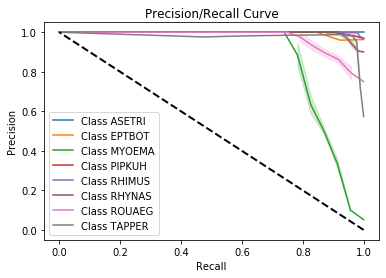

In [26]:
## Precision/Recall Curves per class
### The following curves are generated s.t each point is a model from differing thresholds
from sklearn.metrics import precision_recall_curve

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve')

prec = [0] * 8
rec = [0] * 8
threshold=[]
for i in range(8):
    prec[i], rec[i], threshold = precision_recall_curve(Y_test[:,i], Y_pred[:,i])
    sns.lineplot(x=rec[i],y=prec[i],ax=axs, label='Class '+ getSpecies(i), legend='brief')

# Diagonal line for comparison
plt.plot([1, 0], [0, 1], 'k--', lw=2)

<h2>K-Fold Training and Evaluation</h2>

In [22]:
#Precision Mean and Standard Deviation
#Recall Mean and Standard Deviation
#F1 Measure Mean and Standard Deviation
#True Positive Rate. Mean and Standard Deviation
#False Negative Rate Mean and Standard Deviation
#Best/Worst ROC
#Best/Worst Precision/Recall
#Accuracy Mean and Standard Deviation

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=5
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_acc',patience=25,verbose=1, mode='max',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]

       
    # create and fit the model
   
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_split=0.1,
              verbose=1,
            callbacks=my_callbacks)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['ASETRI','EPTBOT','MYOEMA','PIPKUH','RHIMUS','RHYNAS', 'ROUAEG', 'TAPPER']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

In [ ]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



In [ ]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [ ]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

In [ ]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);
    
    
    

In [ ]:
# plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C = np.array([[  23, 0, 0 , 0, 1,  0,    1,    0],
 [   0, 119   , 1 ,   0,    6,    3,    1,    1],
 [   0,    0,   93,    3,    4,    2,    8,    4],
 [   0,    2,    0,  292,    3,    4,    1,    1],
 [   0,    3,    4,    2, 1768,    3,   11,    8],
 [   0,    3,    0,    5,    2,  257,    2,    2],
 [   0,    2,    5,    1,    4,   0 ,  109,    0],
 [   0,    3,    1,    0,   15,    0,    2,  408]])

cm= C / C.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['ASETRI','EPTBOT','MYOEMA','PIPKUH','RHIMUS','RHYNAS', 'ROUAEG', 'TAPPER']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2>Storing/Loading history and model to file</h2>